In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily
from pysal.lib import weights
from pysal.explore import esda
from splot import esda as esdaplot

In [2]:
PATH_TO_PROCESSED_FILES = Path("../data/processed/")
ROME_GEOJSON = (
    PATH_TO_PROCESSED_FILES / "Rome_urban_zones_with_features_and_emissions_clean__epsg4326.geojson"
)
COMPUTE_G_AUTOCORRELATION = False

## Loading the spatial tessellation

In [3]:
gdf_rome = gpd.read_file(ROME_GEOJSON)
print(gdf_rome.shape)

(155, 21)


# Local spatial autocorrelation

Based on [Local Spatial Autocorrelation — Geographic Data Science with Python](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html)

In [4]:
gdf_rome.drop(columns="geometry").head()

,area_code,area_name,SHAPE_Leng,SHAPE_Area,n_traffic_lights,density_traffic_lights,n_shops,density_shops,perc_roads_bc,car_accidents,perc_people_far_from_public_transport,pop_density,avg_CO_2_per_road,CO_2_alpha,avg_NO_x_per_road,NO_x_alpha,avg_PM_per_road,PM_alpha,avg_VOC_per_road,VOC_alpha
0,10L,Morena,22732.760455,8.947226e+06,10,1.117665,960,107.295822,2.447164,182,2.8,36.9,45.691790,1.379673,0.028145,1.379998,0.000711,1.372780,0.135578,1.360149
1,10A,Don Bosco,8400.069997,2.256348e+06,17,7.534299,1854,821.681815,2.533784,367,93.6,225.9,19.736626,1.506453,0.024918,1.753734,0.000606,1.675556,0.078710,1.261183
2,10B,Appio-Claudio,9265.317994,3.454590e+06,16,4.631520,1236,357.784910,1.465201,239,99.8,86.1,17.311154,1.406042,0.013976,1.272973,0.000557,1.558339,0.067396,1.041726
3,10C,Quarto Miglio,11017.098179,5.030157e+06,9,1.789208,738,146.715093,6.109980,144,35.1,21.7,297.379845,1.387901,0.107992,1.418191,0.001484,1.267525,0.525855,1.523452
4,10D,Pignatelli,5161.962256,9.972986e+05,2,2.005417,178,178.482157,0.000000,50,0.0,66.3,33.474434,1.065894,0.023046,1.000000,0.000804,1.221868,0.103474,1.000000


In [5]:
feature = "car_accidents"

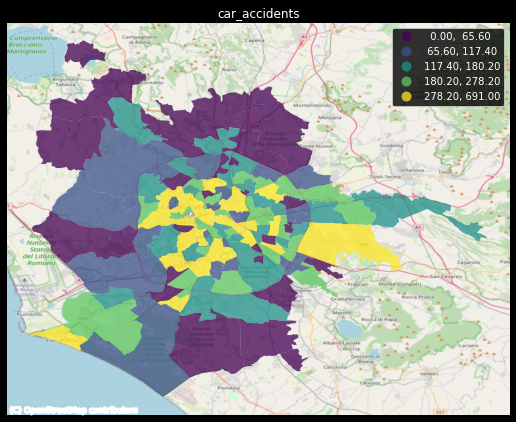

In [6]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_rome.plot(column=feature, 
        cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds={"loc": 1},
        ax=ax
       )
contextily.add_basemap(ax, 
                       crs=gdf_rome.crs, 
                       source=contextily.providers.OpenStreetMap.Mapnik
                      )
ax.set_title(f"{feature}")
ax.set_axis_off()

## Spatial weights

In [7]:
# TODO: choose the right weight
w = weights.Rook.from_dataframe(gdf_rome)
w.transform = 'R'

('WARNING: ', 97, ' is an island (no neighbors)')


In [8]:
gdf_rome_connected = gdf_rome.drop(index=[97])

In [9]:
w = weights.Rook.from_dataframe(gdf_rome_connected)
w.transform = 'R'
assert w.n_components == 1

## Local Moran's I

In [10]:
lisa = esda.moran.Moran_Local(gdf_rome_connected[feature], w)

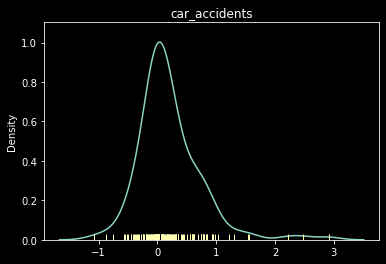

In [11]:
# Draw KDE line
ax = sns.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
ax.set_title(f"{feature}")
_ = sns.rugplot(lisa.Is, ax=ax)

## Plots

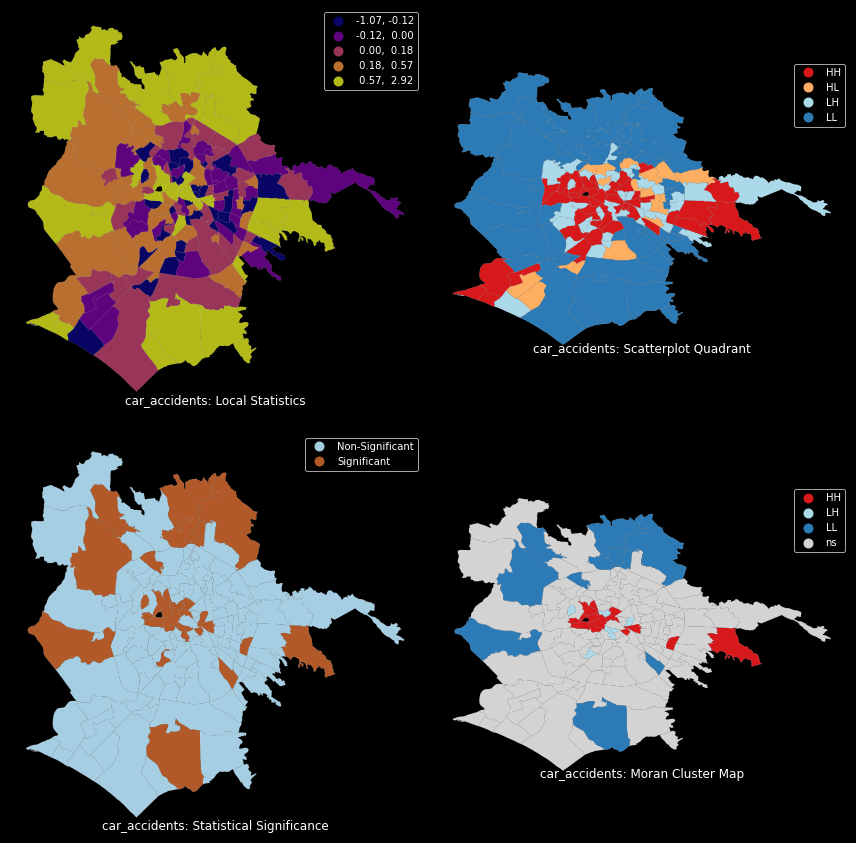

In [12]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
            # Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
gdf_rome_connected.assign(
    Is=lisa.Is
# Plot choropleth of local statistics
).plot(
    column='Is', 
    cmap='plasma', 
    scheme='quantiles',
    k=5, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.75,
    legend=True,
    ax=ax
)

                    # Subplot 2 #
                # Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, gdf_rome_connected, p=1, ax=ax);

                    # Subplot 3 #
                # Significance map
# Grab third axis of local statistics
ax = axs[2]
# 
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05), # Assign 1 if significant, 0 otherwise
    index=gdf_rome_connected.index           # Use the index in the original data
# Recode 1 to "Significant and 0 to "Non-significant"
).map({1: 'Significant', 0: 'Non-Significant'})
# Assign labels to `db` on the fly
gdf_rome_connected.assign(
    cl=labels
# Plot choropleth of (non-)significant areas
).plot(
    column='cl', 
    categorical=True,
    k=2,
    cmap='Paired',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    ax=ax
)

                       
                    # Subplot 4 #
                    # Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, gdf_rome_connected, p=0.05, ax=ax);

                    # Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [f'{feature}: {subtitle}' for subtitle in (
            'Local Statistics', 
            'Scatterplot Quadrant', 
            'Statistical Significance', 
            'Moran Cluster Map')
        ][i], y=0
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

## Getis local statistics

In [13]:
if COMPUTE_G_AUTOCORRELATION:
    # Gi
    go_i = esda.getisord.G_Local(gdf_rome_connected[feature], w)
    # Gi*
    go_i_star = esda.getisord.G_Local(gdf_rome_connected[feature], w, star=True)

In [14]:
def g_map(g, geog, ax, p_threshold=0.05):
    '''
    Create a cluster map
    ...
    
    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    geog   : GeoDataFrame
             Table aligned with values in `g` and containing 
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on
    p_threshold: Significance threshold (Defaults to 0.05)

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    '''
    ec = '0.8'
    
    # Break observations into significant or not
    sig = g.p_sim < p_threshold

    # Plot non-significant clusters
    ns = geog.loc[sig==False, 'geometry']
    ns.plot(ax=ax, color='lightgrey', edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = geog.loc[(g.Zs > 0) & (sig==True), 'geometry']
    hh.plot(ax=ax, color='red', edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = geog.loc[(g.Zs < 0) & (sig==True), 'geometry']
    ll.plot(ax=ax, color='blue', edgecolor=ec, linewidth=0.1)
    # Style and draw
    contextily.add_basemap(
        ax, 
        crs=geog.crs, 
        source=contextily.providers.OpenStreetMap.Mapnik,
    )
    # Flag to add a star to the title if it's G_i*
    st = ''
    if g.star:
        st = '*'
    # Add title
    ax.set_title(f'G{st} statistic for Pct of Leave votes', size=15)
    # Remove axis for aesthetics
    ax.set_axis_off()
    return ax

In [15]:
if COMPUTE_G_AUTOCORRELATION:
    # Setup figure and axes
    f, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Loop over the two statistics
    for g, ax in zip([go_i, go_i_star], axs.flatten()):
        # Generate the statistic's map
        ax = g_map(g, gdf_rome_connected, ax)
    # Tight layout to minimise blank spaces
    f.tight_layout()
    # Render
    plt.show()

# Watermark

In [16]:
%load_ext watermark
%watermark

Last updated: 2022-03-17T22:59:19.236180+01:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 8.0.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 4.4.0-210-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit



In [17]:
%watermark --iversions

matplotlib: 3.5.1
sys       : 3.8.12 | packaged by conda-forge | (default, Jan 30 2022, 23:42:07) 
[GCC 9.4.0]
seaborn   : 0.11.2
contextily: 1.2.0
splot     : 1.1.4
pandas    : 1.4.1
geopandas : 0.10.2
libpysal  : 4.6.0
esda      : 2.4.1

